# Convolutional Neural Network vs. Vision Transformer for Image Classification
David Dabreo, Robert Pianezza, Huzefa Paliwala, Siddhant Das, David Houle-Tymeczko

## Introduction
This project is based on the paper called *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale* by Dosovitskiy et. al (2021), which introduced the use of transformers for image-based tasks. In the paper, they compare the performance of a few vision transformer (ViT) models to that of state of the art convoluational neural networks (CNNs) for image classification.

We attempt to replicate one of the experiments in the paper by evaluating the accuracy of ViT-base and Big Transfer (BiT) on the ImageNet dataset.

Note: We refer to the ILSVRC2012 ImageNet dataset as "ImageNet", which is a subset of the full dataset on 1000 classes.

## Setup

### Imports and Models

In [2]:
import numpy as np
import PIL
import torch
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, BitImageProcessor, BitForImageClassification


DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Both ViT and BiT models classify images into one of 1000 classes from ImageNet
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224').eval().to(DEVICE)
feature_extractor = BitImageProcessor.from_pretrained("google/bit-50")
bit_model = BitForImageClassification.from_pretrained("google/bit-50").eval().to(DEVICE)
print(DEVICE)

c:\Users\David\anaconda3\envs\vit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### Datasets

In [3]:
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, annotations_file), 
            sep=',', header=0, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'), 
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image'] + '.JPEG'
        image = PIL.Image.open(os.path.join(self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

In [4]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, 'val_annotations.txt'),
            sep='\t', header=None, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'),
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image']
        image = PIL.Image.open(os.path.join(
            self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")[
                'pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

## Demo

In [5]:
# Returns the class index of the predicted class
def classify(model, processor, image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx


def load_data(annotations, directory=os.path.join('tiny_imagenet', 'val')):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.JPEG'):
                img = PIL.Image.open(os.path.join(root, file))
                data.append((img, ))
    return data

def load_annotations(directory=os.path.join('tiny_imagenet')):
    filepath = os.path.join(directory, 'val', 'val_annotations.txt')
    annotations = pd.read_csv(filepath, sep='\t', header=None) 
    annotations = annotations.loc[:, [0, 1]].rename(
        columns={0: 'filename', 1: 'wnid'})
    classes = pd.read_csv(os.path.join(directory, 'words.txt'), sep='\t', header=None).rename(columns={0: 'wnid', 1: 'class'})
    annotations['class'] = annotations['wnid'].map(classes.set_index('wnid')['class'])
    annotations.drop(columns=['wnid'], inplace=True)
    return annotations

annotations = load_annotations()

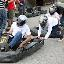

In [6]:
# imgs, labels = next(iter(dataloader))
data = TinyImageNetDataset(os.path.join('tiny_imagenet','val'))
img, label = data[0]
display(img)

In [7]:
# vit_model = vit_model.to(DEVICE)
# bit_model = bit_model.to(DEVICE)


# vit_pred_idx = classify(vit_model, processor, img)
# print("ViT prediction:", vit_model.config.id2label[vit_pred_idx])
# bit_pred_idx = classify(bit_model, feature_extractor, img)
# print("BiT prediction:", bit_model.config.id2label[bit_pred_idx])
# ground_truth = annotations.loc[0 , 'class']
# print("Ground truth:", ground_truth)

## Analysis

### Tiny ImageNet
- subset of ImageNet
- validation set contains 10,000 images and only 200 of the original 1000 classes

In [8]:
annotations.nunique(0)

filename    10000
class         200
dtype: int64

In [9]:
import time
data_dir = os.path.join('tiny_imagenet', 'val')
vit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=processor), batch_size=64)
bit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=feature_extractor), batch_size=64)

def get_accuracy_and_save(model, dataloader: DataLoader, device=torch.device('cpu'), filename=None):
    """
    Compute the accuracy of a model on a given DataLoader, 
    and optionally save the predictions and labels.
    
    Args:
        model: The model to evaluate.
        dataloader: DataLoader providing the dataset.
        device: The device on which to perform computations.
        filename: File to save predictions and labels (optional).
    
    Returns:
        Tuple containing accuracy and time taken for evaluation.
    """
    correct = 0
    all_preds = []
    all_labels = []
    total = len(dataloader.dataset)
    start = time.time()
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            labels = labels.to(device)
            imgs = imgs.to(device)
            outputs = model(imgs)
            pred = outputs.logits.argmax(-1)
            correct += (pred == labels).sum().item()
            all_preds.append(pred.cpu().numpy())  # Move predictions to CPU
            all_labels.append(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start
    # Optionally save predictions and labels
    if filename is not None:
        with open(filename, 'wb') as f:
            pickle.dump({'preds': np.concatenate(all_preds), 
                         'labels': np.concatenate(all_labels),
                         'accuracy': accuracy,
                        'time_taken': time_taken
                }, f)
        print(f"Saved results to {filename}")
    
    return accuracy, time_taken






In [10]:
# vit_accuracy, vit_time_taken = get_accuracy_and_save(vit_model, vit_dataloader, device=DEVICE, filename='vit_tiny_imagenet.pkl')
# bit_accuracy, bit_time_taken = get_accuracy_and_save(bit_model, bit_dataloader, device=DEVICE, filename='bit_tiny_imagenet.pkl')
# print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
# print(f"Time taken: {vit_time_taken:.2f}s")
# print()
# print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
# print(f"Time taken: {bit_time_taken:.2f}s")

In [11]:
def load_model_data(filename):
    with open(filename, 'rb') as f:
       data = pickle.load(f)
    return data['preds'], data['labels'], data['accuracy'], data['time_taken']


In [12]:


# Example: Load confusion matrix data for ViT and BiT
vit_preds, vit_labels, _, _ = load_model_data('vit_tiny_imagenet.pkl')
bit_preds, bit_labels, _, _ = load_model_data('bit_tiny_imagenet.pkl')

# Compute confusion matrices for both models
cm_vit = confusion_matrix(vit_labels, vit_preds)
cm_bit = confusion_matrix(bit_labels, bit_preds)



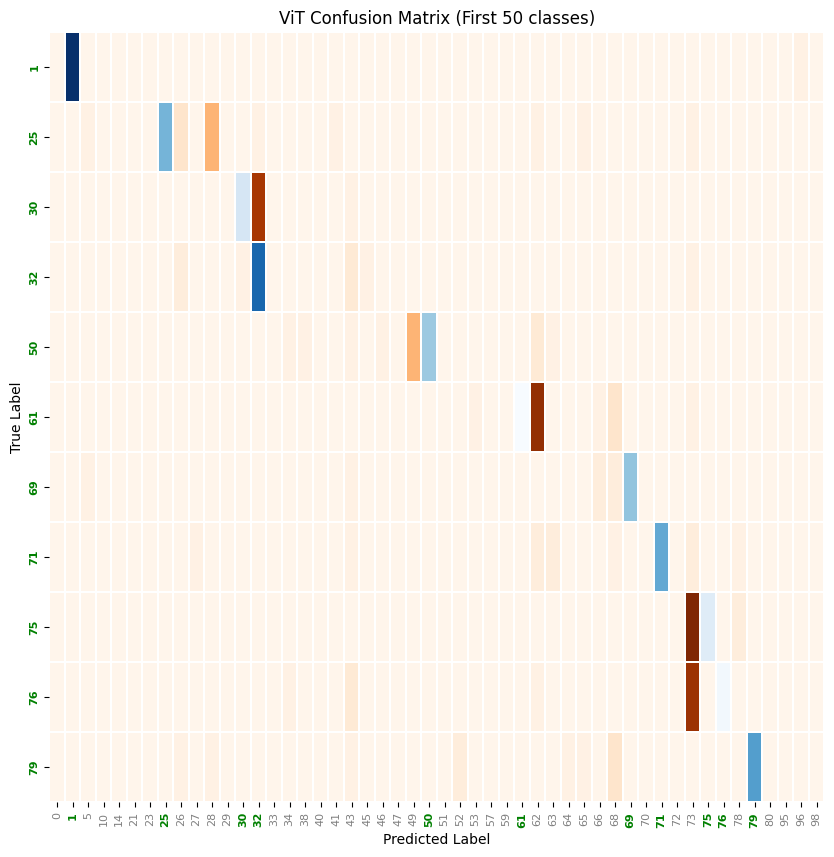

In [13]:
num_classes_to_plot = 50
skip = 1
# Get unique labels from the true labels
vit_true_classes = np.unique(vit_labels)
vit_pred_classes = np.unique(vit_preds)

class_names = [label for label in np.unique(np.concatenate([vit_true_classes, vit_pred_classes]))]

# Filter rows based on true classes
true_class_indices = [i for i, label in enumerate(class_names[:num_classes_to_plot:skip]) if label in vit_true_classes]


# Filter the confusion matrix to include only rows for true classes and the first 50 columns
cm_vit_filtered = cm_vit[np.ix_(true_class_indices, range(0, num_classes_to_plot, skip))]

# Proceed if cm_bit_filtered is valid
if cm_vit_filtered.size > 0:
    filtered_vit_pred_classes = [class_names[i] for i in true_class_indices]

    # Create a mask for matching rows and columns
    mask_match = np.zeros_like(cm_vit_filtered, dtype=bool)
    for i, row_label in enumerate(filtered_vit_pred_classes):
        for j, col_label in enumerate(vit_pred_classes[:num_classes_to_plot:skip]):
            if row_label == col_label:
                mask_match[i, j] = True

# Plot the heatmap for the filtered confusion matrix
plt.figure(figsize=(10, 10))

ax = sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="d",
    cmap="Blues",  # Custom colormap
    xticklabels=vit_pred_classes[:num_classes_to_plot:skip],
    yticklabels=filtered_vit_pred_classes,
    mask=~mask_match,  # Mask non-matching rows and columns
    cbar=False
)

# Highlight specific yticklabels
yticklabels = ax.get_yticklabels()
for label in yticklabels:
     class_label = (label.get_text())
     if class_label in  map(str, vit_true_classes):
        label.set_color("green")
        label.set_fontweight("bold")
        label.set_fontsize(12)
     else:
        label.set_alpha(0.5)

# Highlight specific xticklabels
xticklabels = ax.get_xticklabels()
for label in xticklabels:
    class_label = (label.get_text())
    if class_label in  map(str, vit_true_classes):
        label.set_color("green")
        label.set_fontweight("bold")
        label.set_fontsize(12)
    else:
        label.set_alpha(0.5)

# Add a second heatmap overlay to highlight incorrect predictions
sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="",
    cmap="Oranges",  # Different colormap for incorrect predictions
    xticklabels=vit_pred_classes[:num_classes_to_plot:skip],
    yticklabels=filtered_vit_pred_classes,
    mask=mask_match,  # Mask matching predictions
    cbar=False,
    linewidths=0.1,
)

# Add labels and title
plt.title("ViT Confusion Matrix (First 50 classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()




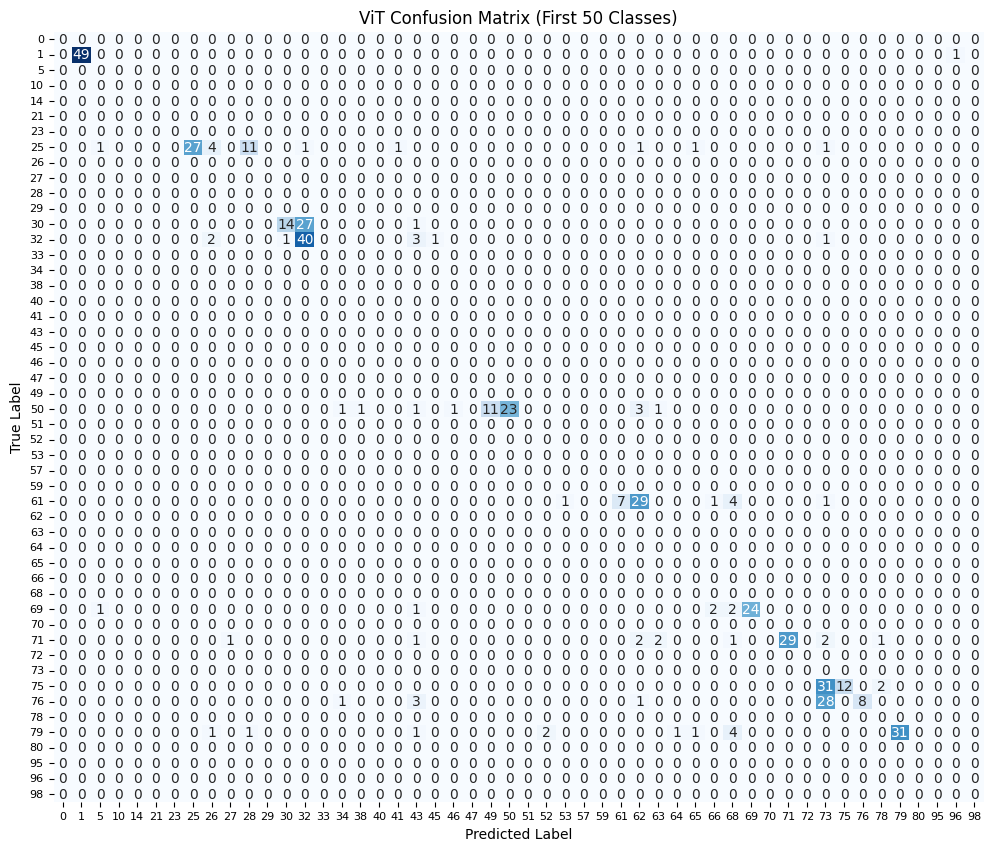

In [14]:
num_classes_to_plot = 50
class_names = [f'{label}' for label in np.unique(np.concatenate([vit_true_classes, vit_pred_classes]))]

# Select the first 5 classes from the confusion matrix
cm_vit_filtered = cm_vit[:num_classes_to_plot, :num_classes_to_plot]

# Plot confusion matrix for ViT with reduced font size for labels
plt.figure(figsize=(12, 10))
sns.heatmap(cm_vit_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:num_classes_to_plot], yticklabels=class_names[:num_classes_to_plot], cbar=False)
plt.title('ViT Confusion Matrix (First 50 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()




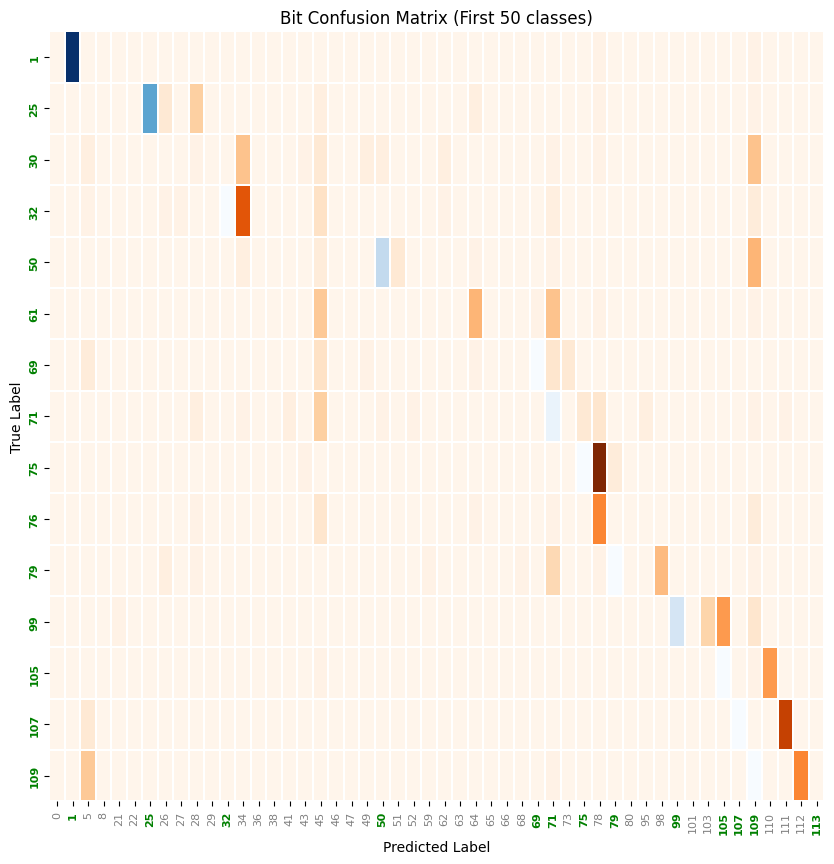

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

num_classes_to_plot = 50
skip = 1

# Get unique labels from the true labels
bit_true_classes = np.unique(bit_labels)
bit_pred_classes = np.unique(bit_preds)
#print(bit_true_classes)
# Combine unique true and predicted classes for class names
class_names = [label for label in np.unique(np.concatenate([bit_true_classes, bit_pred_classes]))]

# Filter rows based on true classes
true_class_indices = [i for i, label in enumerate(class_names[:num_classes_to_plot:skip]) if label in bit_true_classes]



cm_bit_filtered = cm_bit[np.ix_(true_class_indices, range(0, num_classes_to_plot, skip))]
    #print(f"Filtered confusion matrix shape: {cm_bit_filtered.shape}")


# Proceed if cm_bit_filtered is valid
if cm_bit_filtered.size > 0:
    filtered_bit_pred_classes = [class_names[i] for i in true_class_indices]

    # Create a mask for matching rows and columns
    mask_match = np.zeros_like(cm_bit_filtered, dtype=bool)
    for i, row_label in enumerate(filtered_bit_pred_classes):
        for j, col_label in enumerate(bit_pred_classes[:num_classes_to_plot:skip]):
            if row_label == col_label:
                mask_match[i, j] = True

    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        cm_bit_filtered,
        annot=False,
        fmt="d",
        cmap="Blues",  # Custom colormap
        xticklabels=bit_pred_classes[:num_classes_to_plot:skip],
        yticklabels=filtered_bit_pred_classes,
        mask=~mask_match,  # Mask non-matching rows and columns
        cbar=False
    )

    # Highlight specific yticklabels
    yticklabels = ax.get_yticklabels()
    for label in yticklabels:
        class_label = label.get_text()  # No need to convert to int
        #print(f"class labels in y axis {class_label}")
        if class_label in map(str, bit_true_classes):
            label.set_color("green")
            label.set_fontweight("bold")
            label.set_fontsize(12)
        else:
            label.set_alpha(0.5)

    # Highlight specific xticklabels
    xticklabels = ax.get_xticklabels()
    for label in xticklabels:
        class_label = label.get_text()  # No need to convert to int
        if class_label in map(str, bit_true_classes):
            label.set_color("green")
            label.set_fontweight("bold")
            label.set_fontsize(12)
        else:
            label.set_alpha(0.5)

    # Add a second heatmap overlay to highlight incorrect predictions
    sns.heatmap(
        cm_bit_filtered,
        annot=False,
        fmt="",
        cmap="Oranges",  # Different colormap for incorrect predictions
        xticklabels=bit_pred_classes[:num_classes_to_plot:skip],
        yticklabels=filtered_bit_pred_classes,
        mask=mask_match,  # Mask matching predictions
        cbar=False,
        linewidths=0.1,
    )

    # Add labels and title
    plt.title("Bit Confusion Matrix (First 50 classes)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

else:
    print("The confusion matrix is empty or has invalid dimensions.")


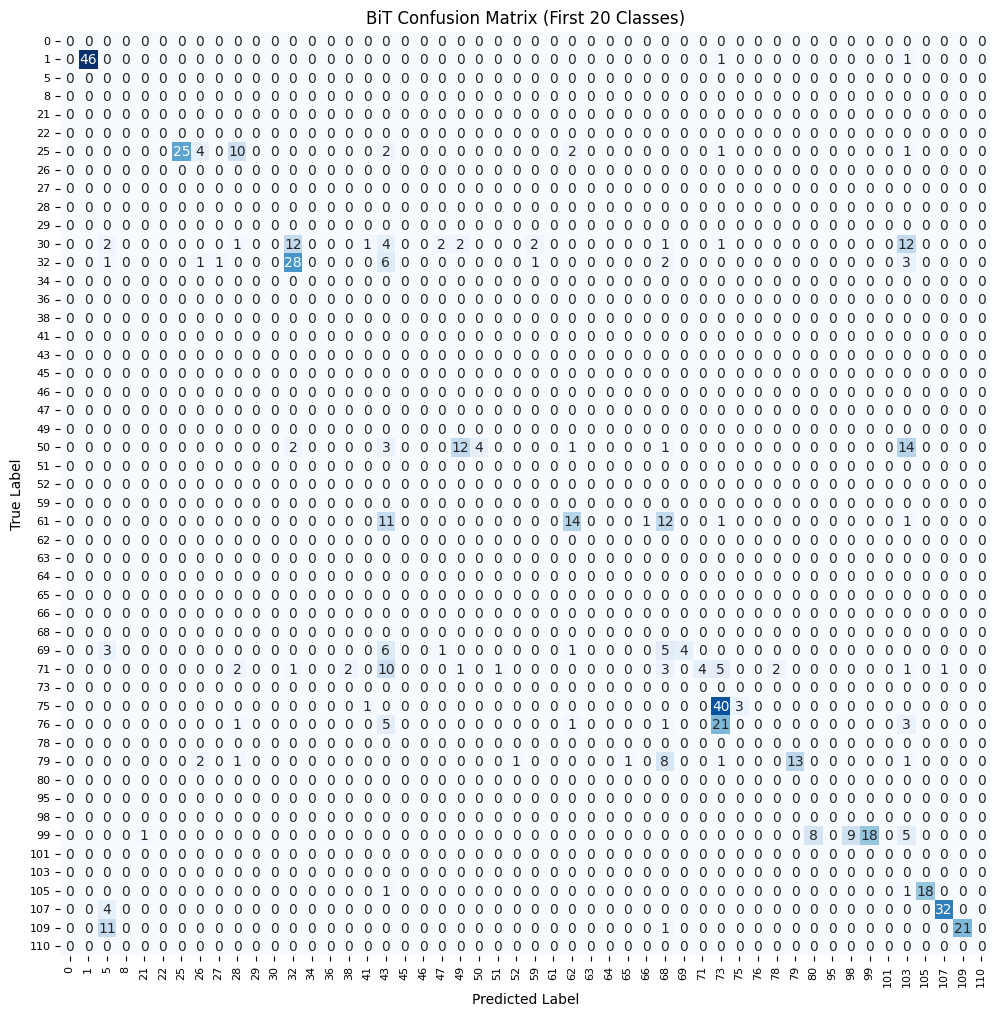

In [16]:
num_classes_to_plot = 50
class_names = [f'{label}' for label in np.unique(np.concatenate([bit_true_classes, bit_pred_classes]))]

# Select the first 5 classes from the confusion matrix
cm_bit_filtered = cm_bit[:num_classes_to_plot, :num_classes_to_plot]

# Plot confusion matrix for ViT with reduced font size for labels
plt.figure(figsize=(12, 12))
sns.heatmap(cm_bit_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:num_classes_to_plot], yticklabels=class_names[:num_classes_to_plot], cbar = False)
plt.title('BiT Confusion Matrix (First 20 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()




In [17]:
def count_correct_preds_for_class(true_classes, pred_classes, target_class):
    # Get the indices where both the true class and predicted class match the target class
    correct_preds = [1 if true == pred == target_class else 0 for true, pred in zip(true_classes, pred_classes)]
    
    # Count the correct predictions for the given class
    correct_count = sum(correct_preds)
    
    return correct_count



In [18]:
target_class = 79
bit_correct_preds_for_class = count_correct_preds_for_class(bit_labels, bit_preds, target_class)
vit_correct_preds_for_class = count_correct_preds_for_class(vit_labels, vit_preds, target_class)
print(f"BIT: Number of correct predictions for class {target_class}: {bit_correct_preds_for_class}")
print(f"VIT: Number of correct predictions for class {target_class}: {vit_correct_preds_for_class}")

BIT: Number of correct predictions for class 79: 13
VIT: Number of correct predictions for class 79: 31


ViT Accuracy: 62.07%
Time taken: 44.57s

BiT Accuracy: 33.18%
Time taken: 109.76s



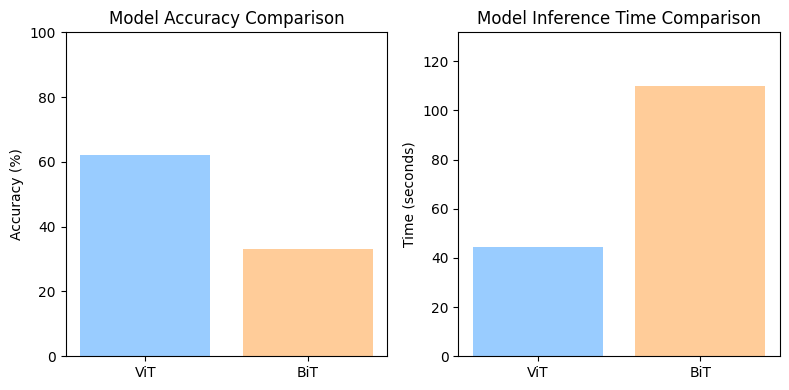

In [19]:

_, _, vit_accuracy, vit_time_taken = load_model_data('vit_tiny_imagenet.pkl')
_, _, bit_accuracy, bit_time_taken = load_model_data('bit_tiny_imagenet.pkl')
# Model names
models = ['ViT', 'BiT']

# Accuracy and time taken values
accuracies = [vit_accuracy * 100, bit_accuracy * 100]
times_taken = [vit_time_taken, bit_time_taken]


# Display results
for model, acc, time_taken in zip(['ViT', 'BiT'], [vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]):
    print(f"{model} Accuracy: {acc:.2f}%\nTime taken: {time_taken:.2f}s\n")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, (data, title, ylabel, ylim) in enumerate(zip([[vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]],
                                                   ['Model Accuracy Comparison', 'Model Inference Time Comparison'],
                                                   ['Accuracy (%)', 'Time (seconds)'],
                                                   [100, max([vit_time_taken, bit_time_taken]) * 1.2])):
    ax[i].bar(['ViT', 'BiT'], data, color=['#99CCFF', '#FFCC99'])
    ax[i].set_title(title)
    ax[i].set_ylabel(ylabel)
    ax[i].set_ylim(0, ylim)

plt.tight_layout()
plt.show()


### ImageNet
- validation set: 50,000 images split among 1000 classes
- we use the validation set because the test set does not have publically-available ground-truth labels
    - but we still want to avoid using images that the models were trained on

In [20]:
data_dir = 'imagenet'
annotations_file = 'LOC_val_solution.csv'
vit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=processor), batch_size=64)
bit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=feature_extractor), batch_size=64)




In [ ]:
vit_accuracy, vit_time_taken = get_accuracy_and_save(vit_model, vit_dataloader, device=DEVICE, filename='vit_imagenet.pkl')
bit_accuracy, bit_time_taken = get_accuracy_and_save(bit_model, bit_dataloader, device=DEVICE, filename='bit_imagenet.pkl')

print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
print(f"Time taken: {vit_time_taken:.2f}s")
print()
print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
print(f"Time taken: {bit_time_taken:.2f}s")

In [22]:
# Example: Load confusion matrix data for ViT and BiT
vit_preds, vit_labels, _, _ = load_model_data('vit_imagenet.pkl')
bit_preds, bit_labels, _, _ = load_model_data('bit_imagenet.pkl')

# Compute confusion matrices for both models
cm_vit = confusion_matrix(vit_labels, vit_preds)
cm_bit = confusion_matrix(bit_labels, bit_preds)

# Get unique labels from the true labels
unique_labels = np.unique(vit_labels)  # Using vit_labels, as an example
class_names = [f'{label}' for label in unique_labels]  # Replace with actual class names if available

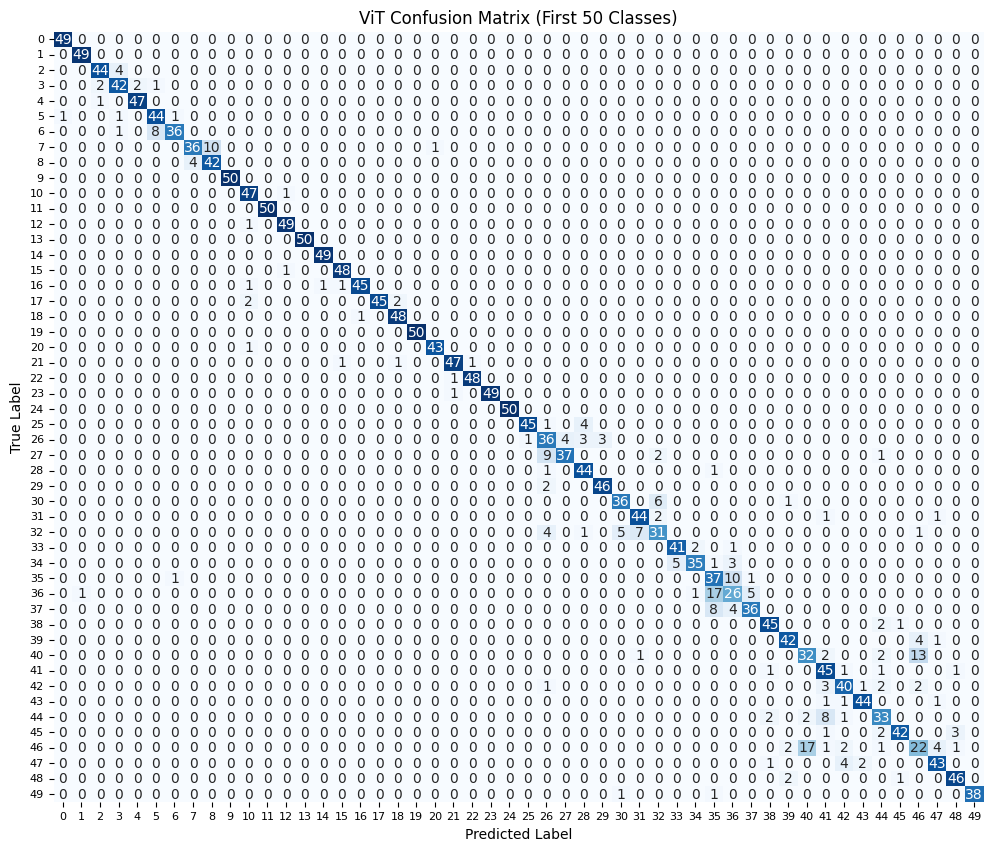

In [23]:
num_classes_to_plot = 20
vit_true_classes = np.unique(vit_labels)
vit_pred_classes = np.unique(vit_preds)
num_classes_to_plot = 50
class_names = [label for label in np.unique(np.concatenate([vit_true_classes, vit_pred_classes]))]

# Select the first 5 classes from the confusion matrix
cm_vit_filtered = cm_vit[:num_classes_to_plot, :num_classes_to_plot]

# Plot confusion matrix for ViT with reduced font size for labels
plt.figure(figsize=(12, 10))
sns.heatmap(cm_vit_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:num_classes_to_plot], yticklabels=class_names[:num_classes_to_plot], cbar=False)
plt.title('ViT Confusion Matrix (First 50 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

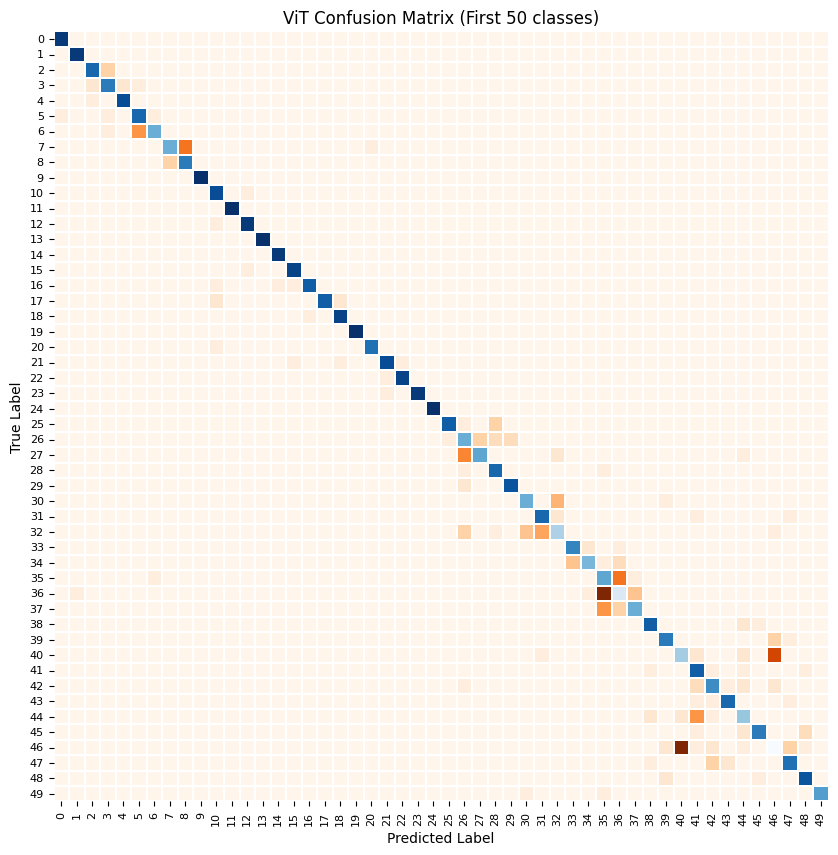

In [25]:


# Select the first 20 classes from the confusion matrix
num_classes_to_plot = 50
skip = 1
cm_vit_filtered = cm_vit[:num_classes_to_plot:skip, :num_classes_to_plot:skip]

# Create a mask to distinguish between correct and incorrect predictions
mask_correct = np.eye(cm_vit_filtered.shape[0], dtype=bool)

# Create a custom colormap
cmap = sns.color_palette(["#d4f7d4", "#f7d4d4"])  # Green for correct, red for incorrect

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="d",
    cmap="Blues",  # Use the custom colormap
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=~mask_correct,  # Highlight correct predictions
    cbar=False
)
sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="",
    cmap="Oranges",  # Highlight incorrect predictions
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=mask_correct,  # Ignore correct predictions
    cbar=False,
    linewidths=0.1,
)

# Labels and title
plt.title("ViT Confusion Matrix (First 50 classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


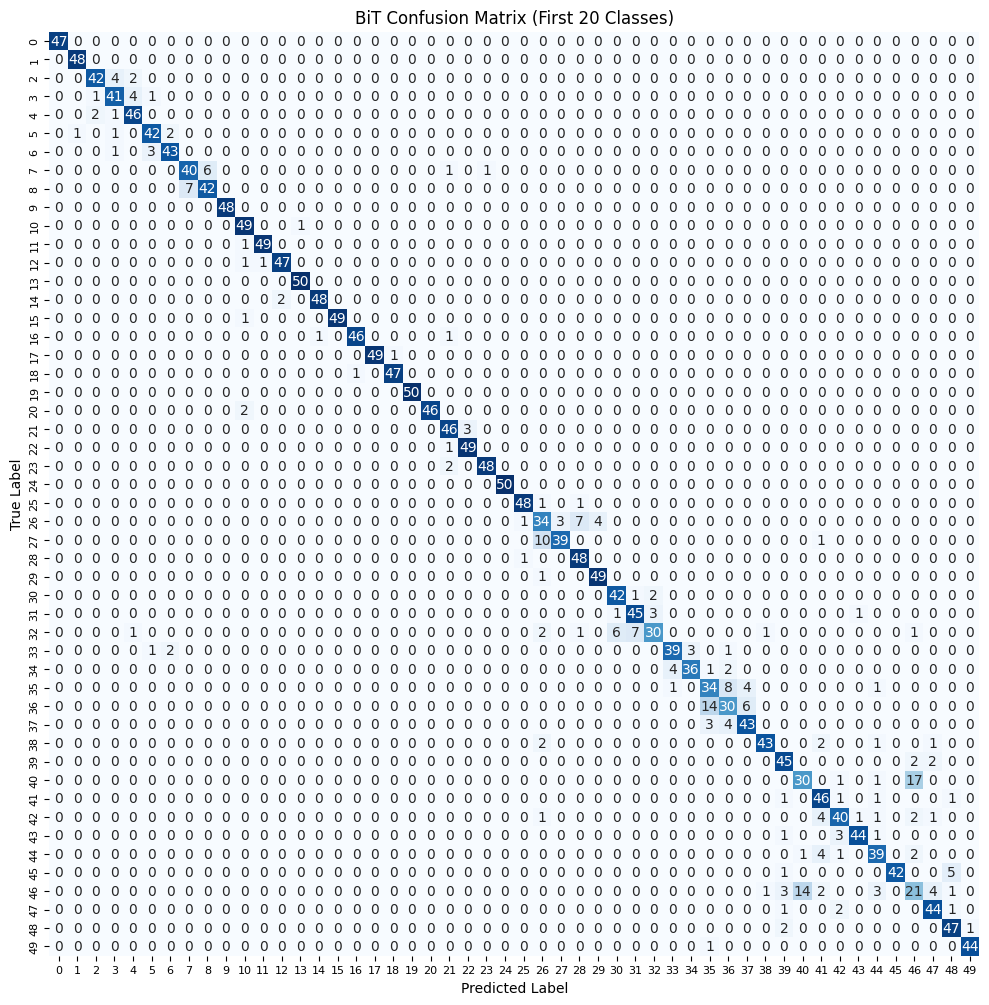

In [26]:
num_classes_to_plot = 50
bit_true_classes = np.unique(bit_labels)
bit_pred_classes = np.unique(bit_preds)
class_names = [f'{label}' for label in np.unique(np.concatenate([bit_true_classes, bit_pred_classes]))]

# Select the first 5 classes from the confusion matrix
cm_bit_filtered = cm_bit[:num_classes_to_plot, :num_classes_to_plot]

# Plot confusion matrix for ViT with reduced font size for labels
plt.figure(figsize=(12, 12))
sns.heatmap(cm_bit_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:num_classes_to_plot], yticklabels=class_names[:num_classes_to_plot], cbar = False)
plt.title('BiT Confusion Matrix (First 20 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


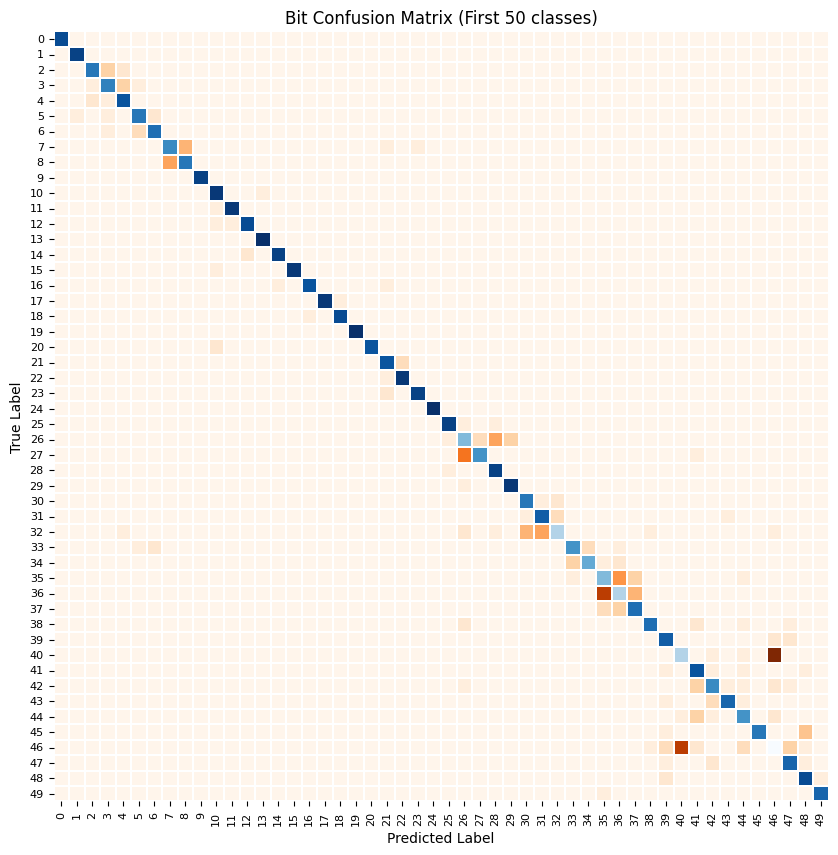

In [27]:


# Select the first 20 classes from the confusion matrix
num_classes_to_plot = 50
skip = 1
cm_bit_filtered = cm_bit[:num_classes_to_plot:skip, :num_classes_to_plot:skip]

# Create a mask to distinguish between correct and incorrect predictions
mask_correct = np.eye(cm_bit_filtered.shape[0], dtype=bool)

# Create a custom colormap
cmap = sns.color_palette(["#d4f7d4", "#f7d4d4"])  # Green for correct, red for incorrect

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    cm_bit_filtered,
    annot=False,
    fmt="d",
    cmap="Blues",  # Use the custom colormap
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=~mask_correct,  # Highlight correct predictions
    cbar=False
)
sns.heatmap(
    cm_bit_filtered,
    annot=False,
    fmt="",
    cmap="Oranges",  # Highlight incorrect predictions
    xticklabels=class_names[:num_classes_to_plot:skip],
    yticklabels=class_names[:num_classes_to_plot:skip],
    mask=mask_correct,  # Ignore correct predictions
    cbar=False,
    linewidths=0.1,
)

# Labels and title
plt.title("Bit Confusion Matrix (First 50 classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


In [28]:
target_class = 46
bit_correct_preds_for_class = count_correct_preds_for_class(bit_labels, bit_preds, target_class)
vit_correct_preds_for_class = count_correct_preds_for_class(vit_labels, vit_preds, target_class)
print(f"BIT: Number of correct predictions for class {target_class}: {bit_correct_preds_for_class}")
print(f"VIT: Number of correct predictions for class {target_class}: {vit_correct_preds_for_class}")

BIT: Number of correct predictions for class 46: 21
VIT: Number of correct predictions for class 46: 22


ViT Accuracy: 80.32%
Time taken: 439.34s

BiT Accuracy: 80.36%
Time taken: 949.60s



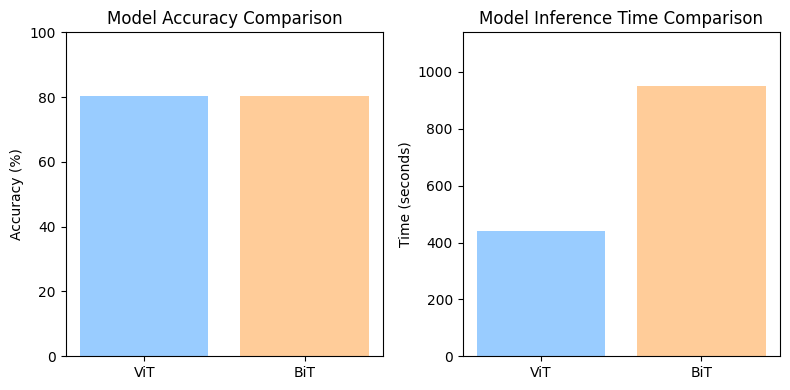

In [29]:
_, _, vit_accuracy, vit_time_taken = load_model_data('vit_imagenet.pkl')
_, _, bit_accuracy, bit_time_taken = load_model_data('bit_imagenet.pkl')
# Model names
models = ['ViT', 'BiT']

# Accuracy and time taken values
accuracies = [vit_accuracy * 100, bit_accuracy * 100]
times_taken = [vit_time_taken, bit_time_taken]


# Display results
for model, acc, time in zip(['ViT', 'BiT'], [vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]):
    print(f"{model} Accuracy: {acc:.2f}%\nTime taken: {time:.2f}s\n")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, (data, title, ylabel, ylim) in enumerate(zip([[vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]],
                                                   ['Model Accuracy Comparison', 'Model Inference Time Comparison'],
                                                   ['Accuracy (%)', 'Time (seconds)'],
                                                   [100, max([vit_time_taken, bit_time_taken]) * 1.2])):
    ax[i].bar(['ViT', 'BiT'], data, color=['#99CCFF', '#FFCC99'])
    ax[i].set_title(title)
    ax[i].set_ylabel(ylabel)
    ax[i].set_ylim(0, ylim)

plt.tight_layout()
plt.show()

## References
ImageNet on Kaggle - https://www.kaggle.com/c/imagenet-object-localization-challenge/overview \
ILSVRC2012 paper - https://arxiv.org/pdf/1409.0575 \
Tiny ImageNet on Kaggle - https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet